In [22]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import torch
from torch.nn import functional as F
from torch import nn
import torchvision

In [23]:
from sklearn.datasets import fetch_openml


X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X = X.values
y = y.astype(int).values

print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


In [24]:
X = ((X / 255.) - .5) * 2

In [25]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.7, random_state=123, stratify=y)

# X_train, X_valid, y_train, y_valid = train_test_split(
#     X_temp, y_temp, test_size=5000, random_state=123, stratify=y_temp)


# # optional to free up some memory by deleting non-used arrays:
# del X_temp, y_temp, X, y

In [34]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x = x.astype(float)
        self.y = y
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [67]:
train_loader = torch.utils.data.DataLoader(Dataset(X_train, y_train), shuffle=True, num_workers=8, batch_size=128)
test_loader = torch.utils.data.DataLoader(Dataset(X_test, y_test), shuffle=False, num_workers=8, batch_size=128)

In [68]:
class Net(nn.Module):
    
    def __init__(self, hidden_size, num_classes):
        super().__init__()
        
        self.linear1 = nn.Linear(784, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = F.softmax(self.linear3(x), dim=-1)
        
        return x

In [69]:
train_losses = []
train_accs = []

test_losses = []
test_accs = []

In [70]:
def train(epoch):
    network.train()
    correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = network(data.float().cuda())
        loss = F.cross_entropy(output, target.cuda())
        loss.backward()
        optimizer.step()
        
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.detach().eq(target.cuda().data.view_as(pred)).sum()
    train_losses.append(loss.item())
    train_accs.append((correct / len(train_loader.dataset)).cpu().item())


In [71]:
def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = network(data.float().cuda())
            test_loss += F.cross_entropy(output, target.cuda()).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.cuda().data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    test_accs.append((correct / len(test_loader.dataset)).cpu().item())
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))

In [72]:
network = Net(128, 10).cuda()
optimizer = torch.optim.Adam(network.parameters(), lr=1e-4)

In [73]:
for epoch in range(1, 50 + 1):
    train(epoch)
    test()


Test set: Avg. loss: 0.0150, Accuracy: 32359/49000 (66%)


Test set: Avg. loss: 0.0138, Accuracy: 36019/49000 (74%)


Test set: Avg. loss: 0.0136, Accuracy: 36563/49000 (75%)


Test set: Avg. loss: 0.0135, Accuracy: 36811/49000 (75%)


Test set: Avg. loss: 0.0134, Accuracy: 36972/49000 (75%)


Test set: Avg. loss: 0.0132, Accuracy: 39219/49000 (80%)


Test set: Avg. loss: 0.0127, Accuracy: 42978/49000 (88%)


Test set: Avg. loss: 0.0124, Accuracy: 44017/49000 (90%)


Test set: Avg. loss: 0.0124, Accuracy: 44195/49000 (90%)


Test set: Avg. loss: 0.0123, Accuracy: 44404/49000 (91%)


Test set: Avg. loss: 0.0123, Accuracy: 44537/49000 (91%)


Test set: Avg. loss: 0.0123, Accuracy: 44442/49000 (91%)


Test set: Avg. loss: 0.0122, Accuracy: 44699/49000 (91%)


Test set: Avg. loss: 0.0122, Accuracy: 44615/49000 (91%)


Test set: Avg. loss: 0.0122, Accuracy: 44882/49000 (92%)


Test set: Avg. loss: 0.0122, Accuracy: 44880/49000 (92%)


Test set: Avg. loss: 0.0121, Accuracy: 44977/49000 (92%

In [74]:
probs = []
targets = []
with torch.no_grad():
        for data, target in test_loader:
            output = network(data.float().cuda())
            probs += output.cpu().numpy().tolist()
            targets += target.cpu().numpy().tolist()

In [75]:
roc_auc_score(targets, probs, average='macro', multi_class='ovr')

0.9948244511737487

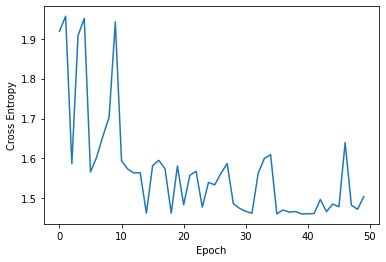

In [86]:
plt.plot(range(len(train_losses)), train_losses)
plt.ylabel('Cross Entropy')
plt.xlabel('Epoch')
#plt.savefig('figures/11_07.png', dpi=300)
plt.show()

In [83]:
train_accs = [x.cpu().item() for x in train_accs]

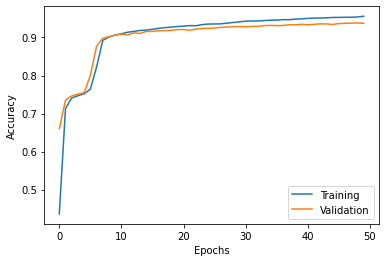

In [84]:
plt.plot(range(len(train_accs)), train_accs,
         label='Training')
plt.plot(range(len(test_accs)), test_accs,
         label='Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
#plt.savefig('figures/11_08.png', dpi=300)
plt.show()